# Directory/File Paths


* `dir_oba`: Define the path to the Xenium onboard analyzer output directory for that patient (i.e., the "raw" data). For instance, `/mnt/cho_lab/bbdata2/outputs/XR4UZH/CHO-014/output-XETG00189__0033935__1014A2-XR4UZH-JH__20240617__193846`.

* `panel_id`: Define the Xenium panel ID (e.g., TUQ97N for Helmsley senescence, XR4UZH for liver/PSC-IBD).
* `dir_xenium`: Define the path to the Xenium panel data. Change it to match your compute environment. Refer to `Data Path (Red = PHI)` column of the table in the ["Compute Environments" section on the "Compute" page on Confluence (click here)](https://mssm-ipm.atlassian.net/wiki/spaces/cholab/pages/857047077/Compute#Environments) for the appropriate entry directory (in this case, `/mnt/cho_lab` for Spark). Refer to the [NFS directory section of that page](https://mssm-ipm.atlassian.net/wiki/spaces/cholab/pages/857047077/Compute#Network-File-System---NFS) for the data sub-directory (here, `bbdata`).

****
**Click this drop-down for code to find the appropriate path to your sample's data automatically!**
<details>
  <summary>Click here for code</summary>
  
  ```python
  import corescpy as cr

  # Define Sample ID, Panel ID, Metadata File Path, etc.
  libid = "50336C"
  panel_id = "TUQ97N"
  direc = "/mnt/cho_lab/bbdata2"
  path_metadata = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
                      f"samples_{panel_id}.csv")
  cap_id = True if panel_id == "TUQ97N" else False  # uppercase ID for TUQ97N

  # Find Data Path Automatically
  metadata = cr.pp.get_metadata_cho(
      direc, path_metadata, samples=libid, path_col_only=True,
      panel_id=panel_id, capitalize_sample=cap_id)  # metadata
  dir_oba = metadata.iloc[0]  # data path
  libid = metadata.index.values[0]  # newly-constructed sample ID
  print(libid, "\n", dir_oba)
  ```
</details>

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import corescpy as cr


panel_id = "TUQ97N"
# run_id = "CHO-009"
# libid = "Uninflamed-50336C"
run_id = "CHO-007"
libid = "Stricture-50006C"
dir_sample = "output-XETG00189__0022406__50006C-TUQ97N-EA__20240411__205514"
col_sample_id = "Sample"  # ideally should reflect appropriate metadata column
image_type = "he"
dir_image = str("/mnt/cho_lab/bbdata1/nfs-data-registries/tissue-registry/"
                f"xenium/{panel_id}/{image_type}")
# dir_image = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
#                 "outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he")
out_dir = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              f"outputs/{panel_id}/nebraska")  # for output: MUST BE WRITEABLE
dir_xenium = f"/mnt/cho_lab/bbdata2/outputs/{panel_id}/{run_id}"
# dir_sample = "output-XETG00189__0010496__50336A-TUQ97N-EA__20240418__170624"

# Construct Input & Output Paths
dir_oba = os.path.join(dir_xenium, dir_sample)  # Xenium OBA data directory
file_image = os.path.join(dir_image, f"ome-tiff/{libid}.ome.tif")
file_align = os.path.join(dir_image, f"alignment/{libid}/matrix.csv")  # align
if out_dir not in [None, False]:
    out_obj = os.path.join(out_dir, f"{libid}.h5ad")  # for object .h5ad file
    out_markers = os.path.join(out_dir, "find_markers")  # find_markers file
    out_dir_plot = os.path.join(out_dir, "plots", libid)  # cluster plots
    [os.makedirs(x, exist_ok=True) for x in [
        out_dir, out_dir_plot, out_markers]]  # make sub-directories if needed
else:
    out_obj, out_markers, out_dir_plot = None, None, None

# Extra
file_ann = os.path.join("~/corescpy/examples/markers_lineages.csv")

## Create Object

## Basic Object

Create the raw `coreSCpy` object.

You can update this initial raw object with previously-saved processed object using `self.update_from_h5ad(out_obj)`.
* In that case, you will almost certainly want to set `kws_pp` (preprocessing parameters) to `None` because the object is already preprocessed. 
* If you wanted to re-preprocess, you'd likely just be working with the raw object anyway and so would use `self.update_fromh5ad()`.

In [2]:
self = cr.Spatial(dir_oba, library_id=libid, col_sample_id=col_sample_id)
# self.update_from_h5ad(os.path.join(
#     out_dir, f"{libid}.h5ad"))  # to load previously processed object



<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022406__50006C-TUQ97N-EA__20240411__205514/
         cell_feature_matrix.h5                                                                                    




Counts: Initial: table


	Observations: 721489

	Genes: 469







 AnnData object with n_obs × n_vars = 721489 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                                           
ABCA7         ENSG00000064687  Gene Expression  Unknown
ACTA2         ENSG00000107796  Gene Expression  Unknown
ACTG2         ENSG00000163017  Gene Expression  Unknown
ADAM15        ENSG00000143537  Gene Expression  Unknown
ADAM28        ENSG00000042980  Gene Expression  Unknown 

  




SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] 

In [27]:
# self.get_layer("counts", inplace=True)
# mgs = mks[mks.Bucket == "SMC"].index.intersection(self.rna.var_names)
# musc = pd.Series([100 * np.mean(self.rna[self.rna.obs[
#     "leiden_res1pt5_dist0_npc30"] == "32"][:, x].X > 0) for x in mgs],
#                  index=mgs)
# musc = dict(musc.round(1))
# ", ".join([f"{musc[i]}% {i}+" for i in musc])

'0.0% ANOS1+, 25.0% CSRP2+, 0.0% C5orf30+, 49.0% ENAH+, 2.1% RIMS1+, 91.7% MYLK+, 95.8% MYH11+, 96.9% ACTG2+, 83.3% CNN1+, 87.5% DES+, 1.0% GPR183+, 94.8% ACTA2+'

## Add H&E

You could also use this same workflow to add, for instance, IF images, etc. Just use the appropriate OME-TIFF and alignment file/directory paths.

1) **FIRST use the following code to convert the NDPI or TIFF to OME-TIFF if needed.**
(Change the libid & file paths as needed.) **`output_ome` MUST BE IN A DIRECTORY FOR WHICH YOU HAVE WRITE PERMISSIONS**. (The code below uses your home directory (`~/`), but you can change that.)

```python
libid = "Uninflamed-50336C"
ndpi = os.path.join(dir_image, f"raw/50336C.ndpi")
output_ome = f"~/{os.path.basename(file_image)}"
cr.tl.write_ome_tif(ndpi, output_ome, bf_cmd="bfconvert")  # convert
```

2) Then **move the file** written to `output_ome` **to the tissue registry** using Globus. The path on the tissue registry should be what you specified for `file_image` (`os.path.join(dir_image, f"ome-tiff/{libid}.ome.tif")`).

3) Delete the temporary file you created in your writeable directory (`output_ome`).

In [33]:
self.add_image(file_image, name=image_type, file_align=file_align)

AssertionError: File /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he/alignment/Stricture-50006C/matrix.csv does not exist.

## Plot Images

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


MemoryError: Unable to allocate 7.13 GiB for an array with shape (1, 74906, 51104) and data type uint16

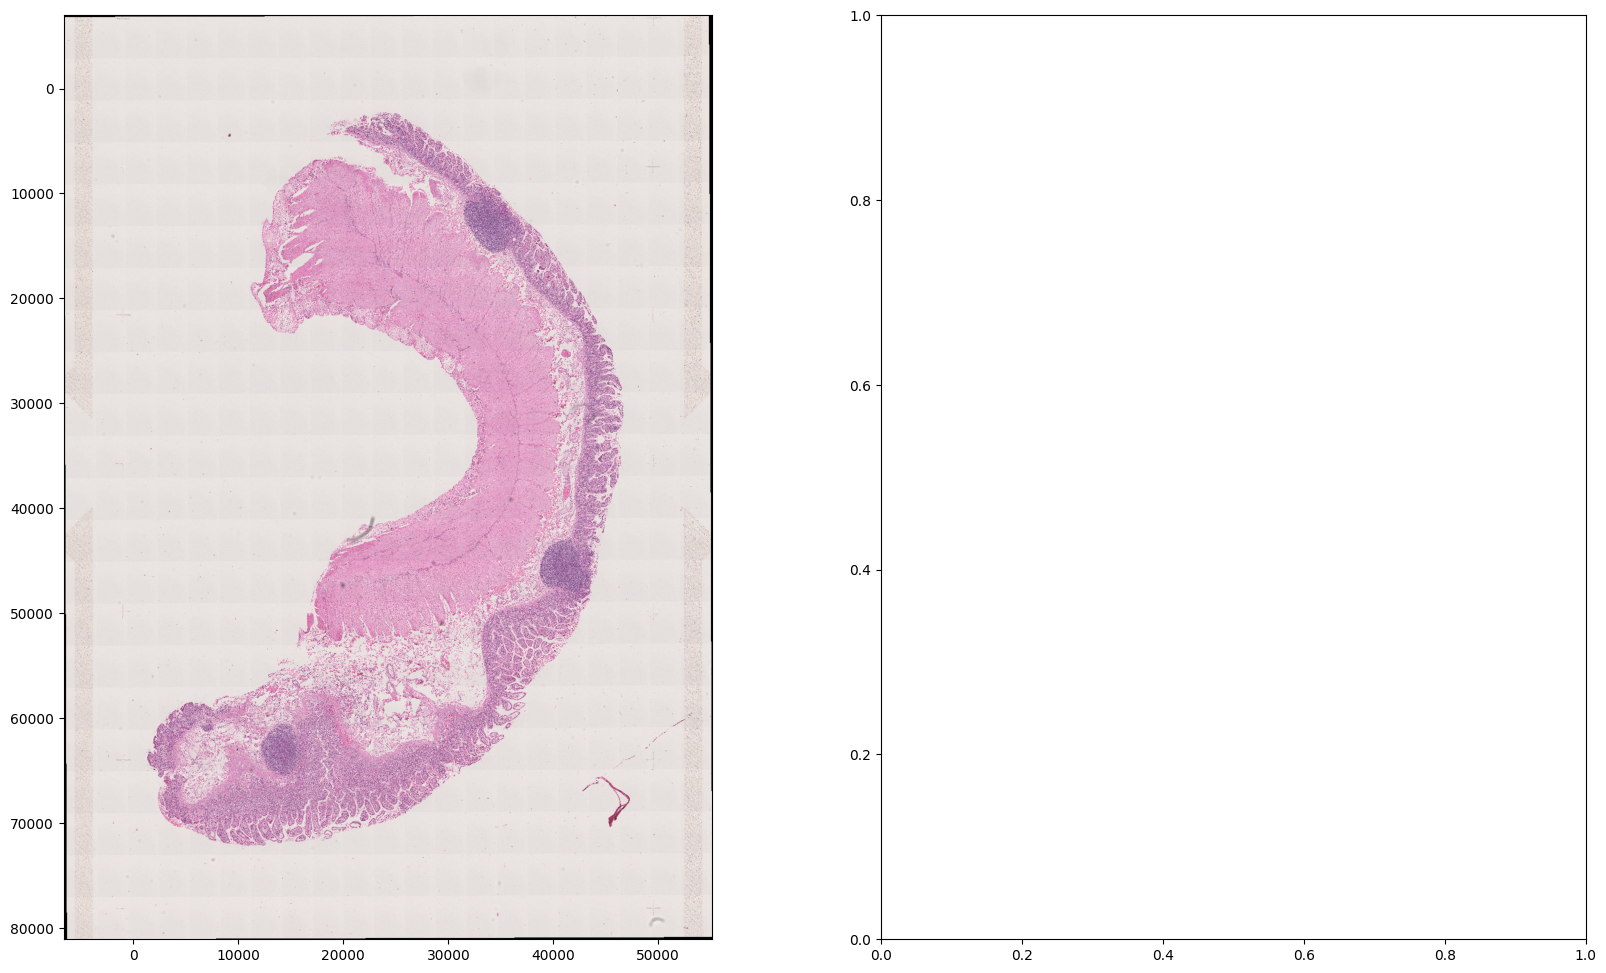

In [13]:
%%time

self.plot_image([image_type, "morphology_focus"])

# Preprocessing & Clustering

For `self.find_markers()`, you can find the top, for instance, five markers by specifying `n_genes=5` instead of `n_genes=None` (which returns a dataframe for ).

## Define Parameters

`outlier_mads` must be a dictionary keyed by column names in `self.rna.obs` or `self.rna.var`. These columns may already exist, or they may be created in steps included in `self.preprocess()` (e.g., `scanpy`-calculated QC metrics). Therefore, the keys in that dictionary may not reflect the convention for the manual filtering (e.g., `cell_filter_ncounts` is the argument passed to `self.preprocess()` for manual/hard-coded filtering, while the key in `outlier_mads` should be `ncounts`.).

Even if a cell or gene passes the `outlier_mads`-defined threshold, if you also specify a manual/hard-coded threshold (i.e., in `kws_filter`), it must pass that threshold too. So you can use, for instance `cell_filter_ncounts=[3, None]` along with `outlier_mads = {"n_counts": [1.25, None]}` to remove outliers while also requiring an absolute minimum of 3 counts (even if 2 counts isn't an outlier).

In [40]:
# Preprocessing Options
outlier_mads = {"n_counts": [1.25, None]}  # automatic outlier detection
kws_filter = dict(cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
                  gene_filter_ncounts=[3, None], custom_thresholds=None
                  )  # manually-defined/hard-coded thresholds
kws_pp = dict(**kws_filter, outlier_mads=outlier_mads,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing
# kws_pp = None   # if loading object already preprocessed

# Clustering Options
genes_subset = None  # use all genes in clustering
# genes_subset = list(pd.read_csv(file_ann).iloc[:, 0])  # only cell markers
resolution = 1.5
n_comps = 30
min_dist = 0

# Standard Cluster Column Names
suffix = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
             f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")
col_cell_type = f"leiden_{suffix}"

## Run & Save Object

`self._columns["col_cell_type"] = col_cell_type` makes it so that certain downstream methods that require a cell type column to be defined can use this one as the default going forward instead of having to specify it every time.

AnnData object with n_obs × n_vars = 465118 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'n_obs_raw'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'

Un-Used Keyword Arguments: {'assay_protein': None, 'col_subject': None, 'col_condition': None, 'col_num_umis': None, 'col_segment': 'region'}




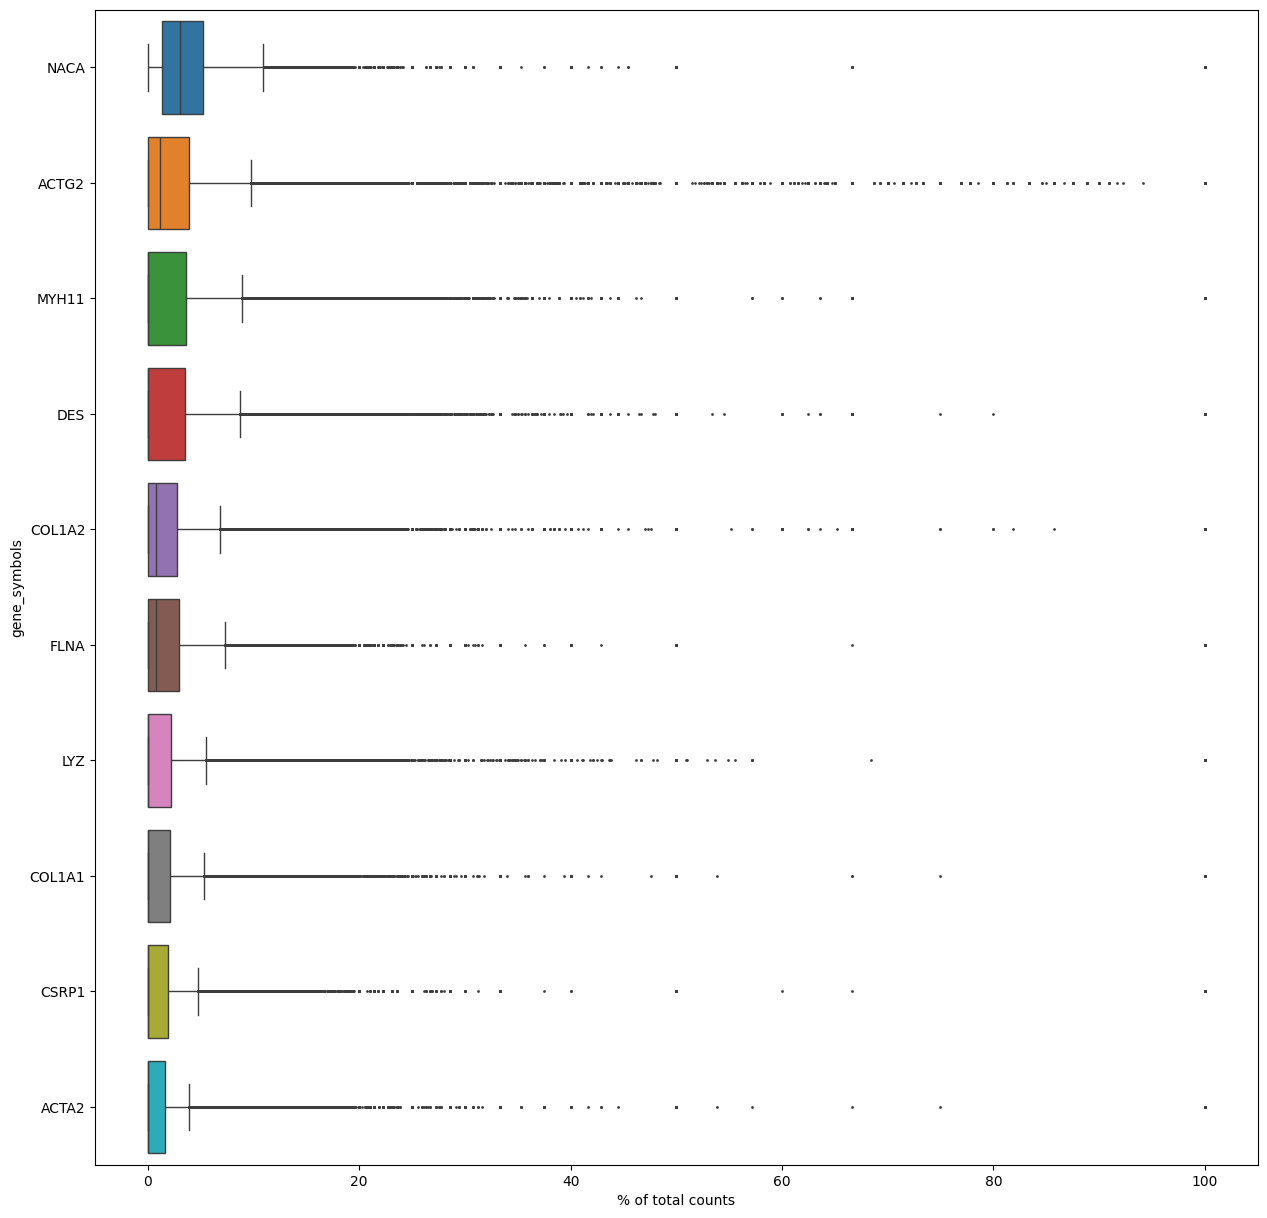



Counts: Initial


	Observations: 465118

	Genes: 469





<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




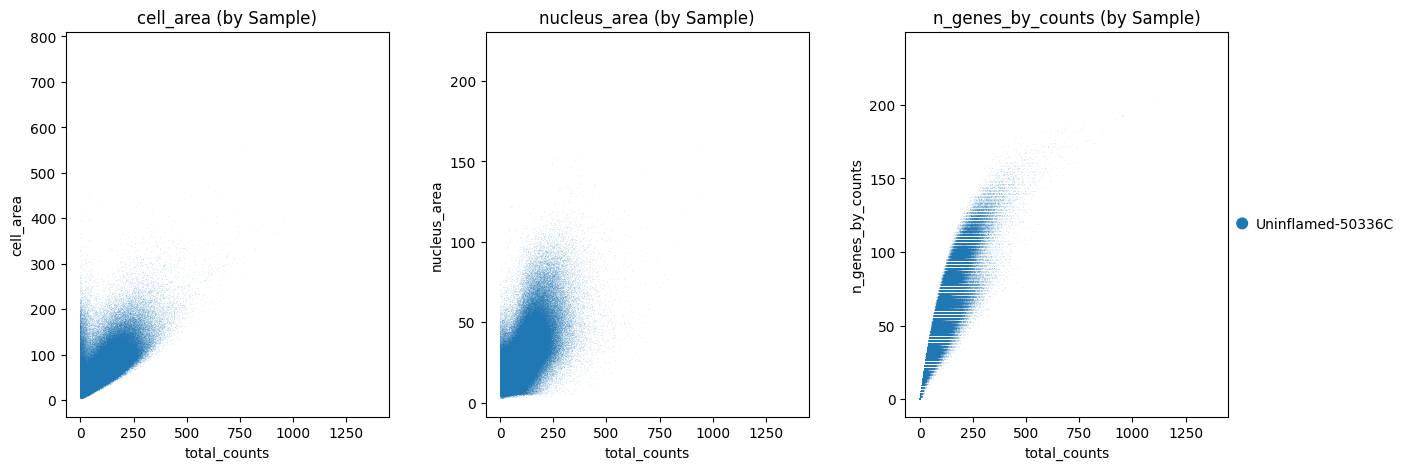


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>


Counts: Post-`min_gene`


	Observations: 460434

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            11525.0     0.032422           0.031907              83.021083   
50%            38583.0     0.103477           0.098466              91.704686   
75%            78972.0     0.246471           0.220316              97.522134   

     total_counts  log1p_total_counts  
25%       15080.0            9.621191  
50%       48129.0           10.781661  
75%      114638.0           11.649544  





Counts: Post-`min_cell`


	Observations: 460434

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            11525.0     0.032422           0.031907              83.021083   
50%            38583.0     0.103477           0.098466              91.704686   
75%            78972.0     0.246471           0.220316              97.52213

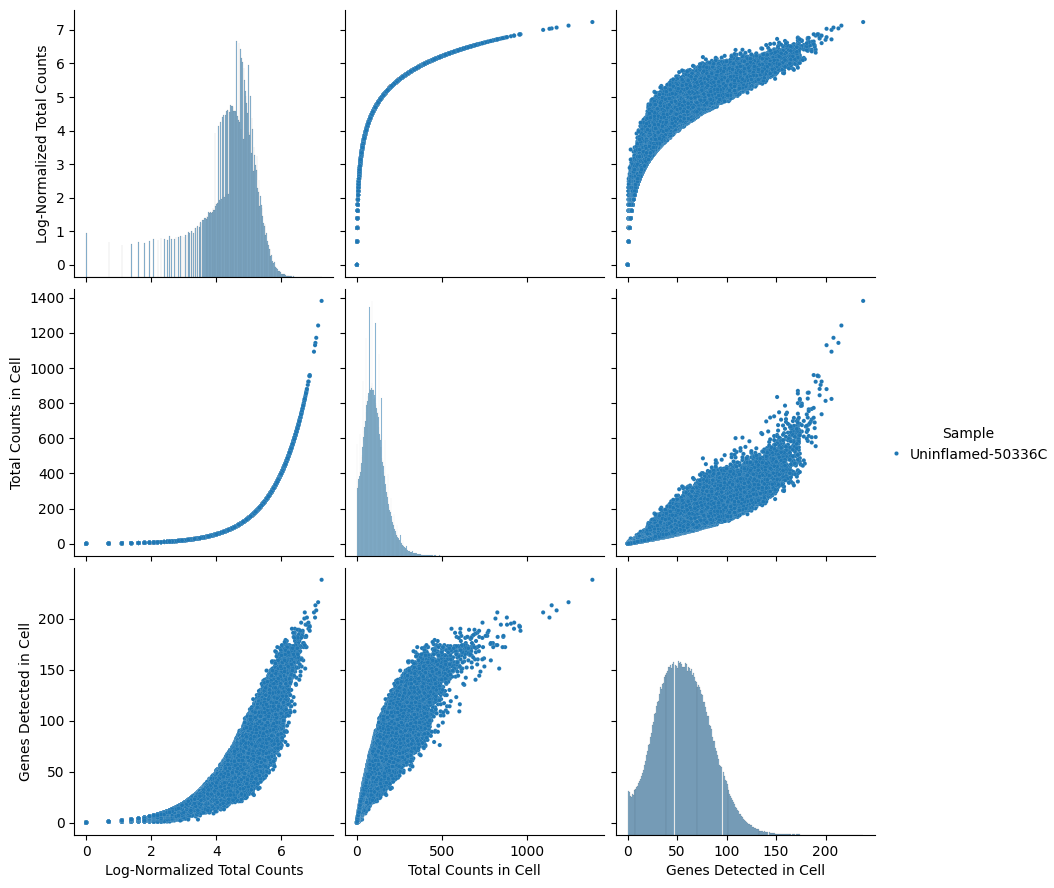

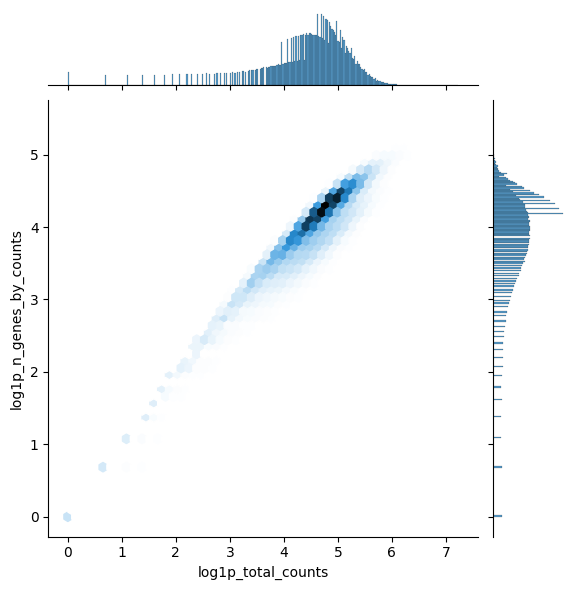

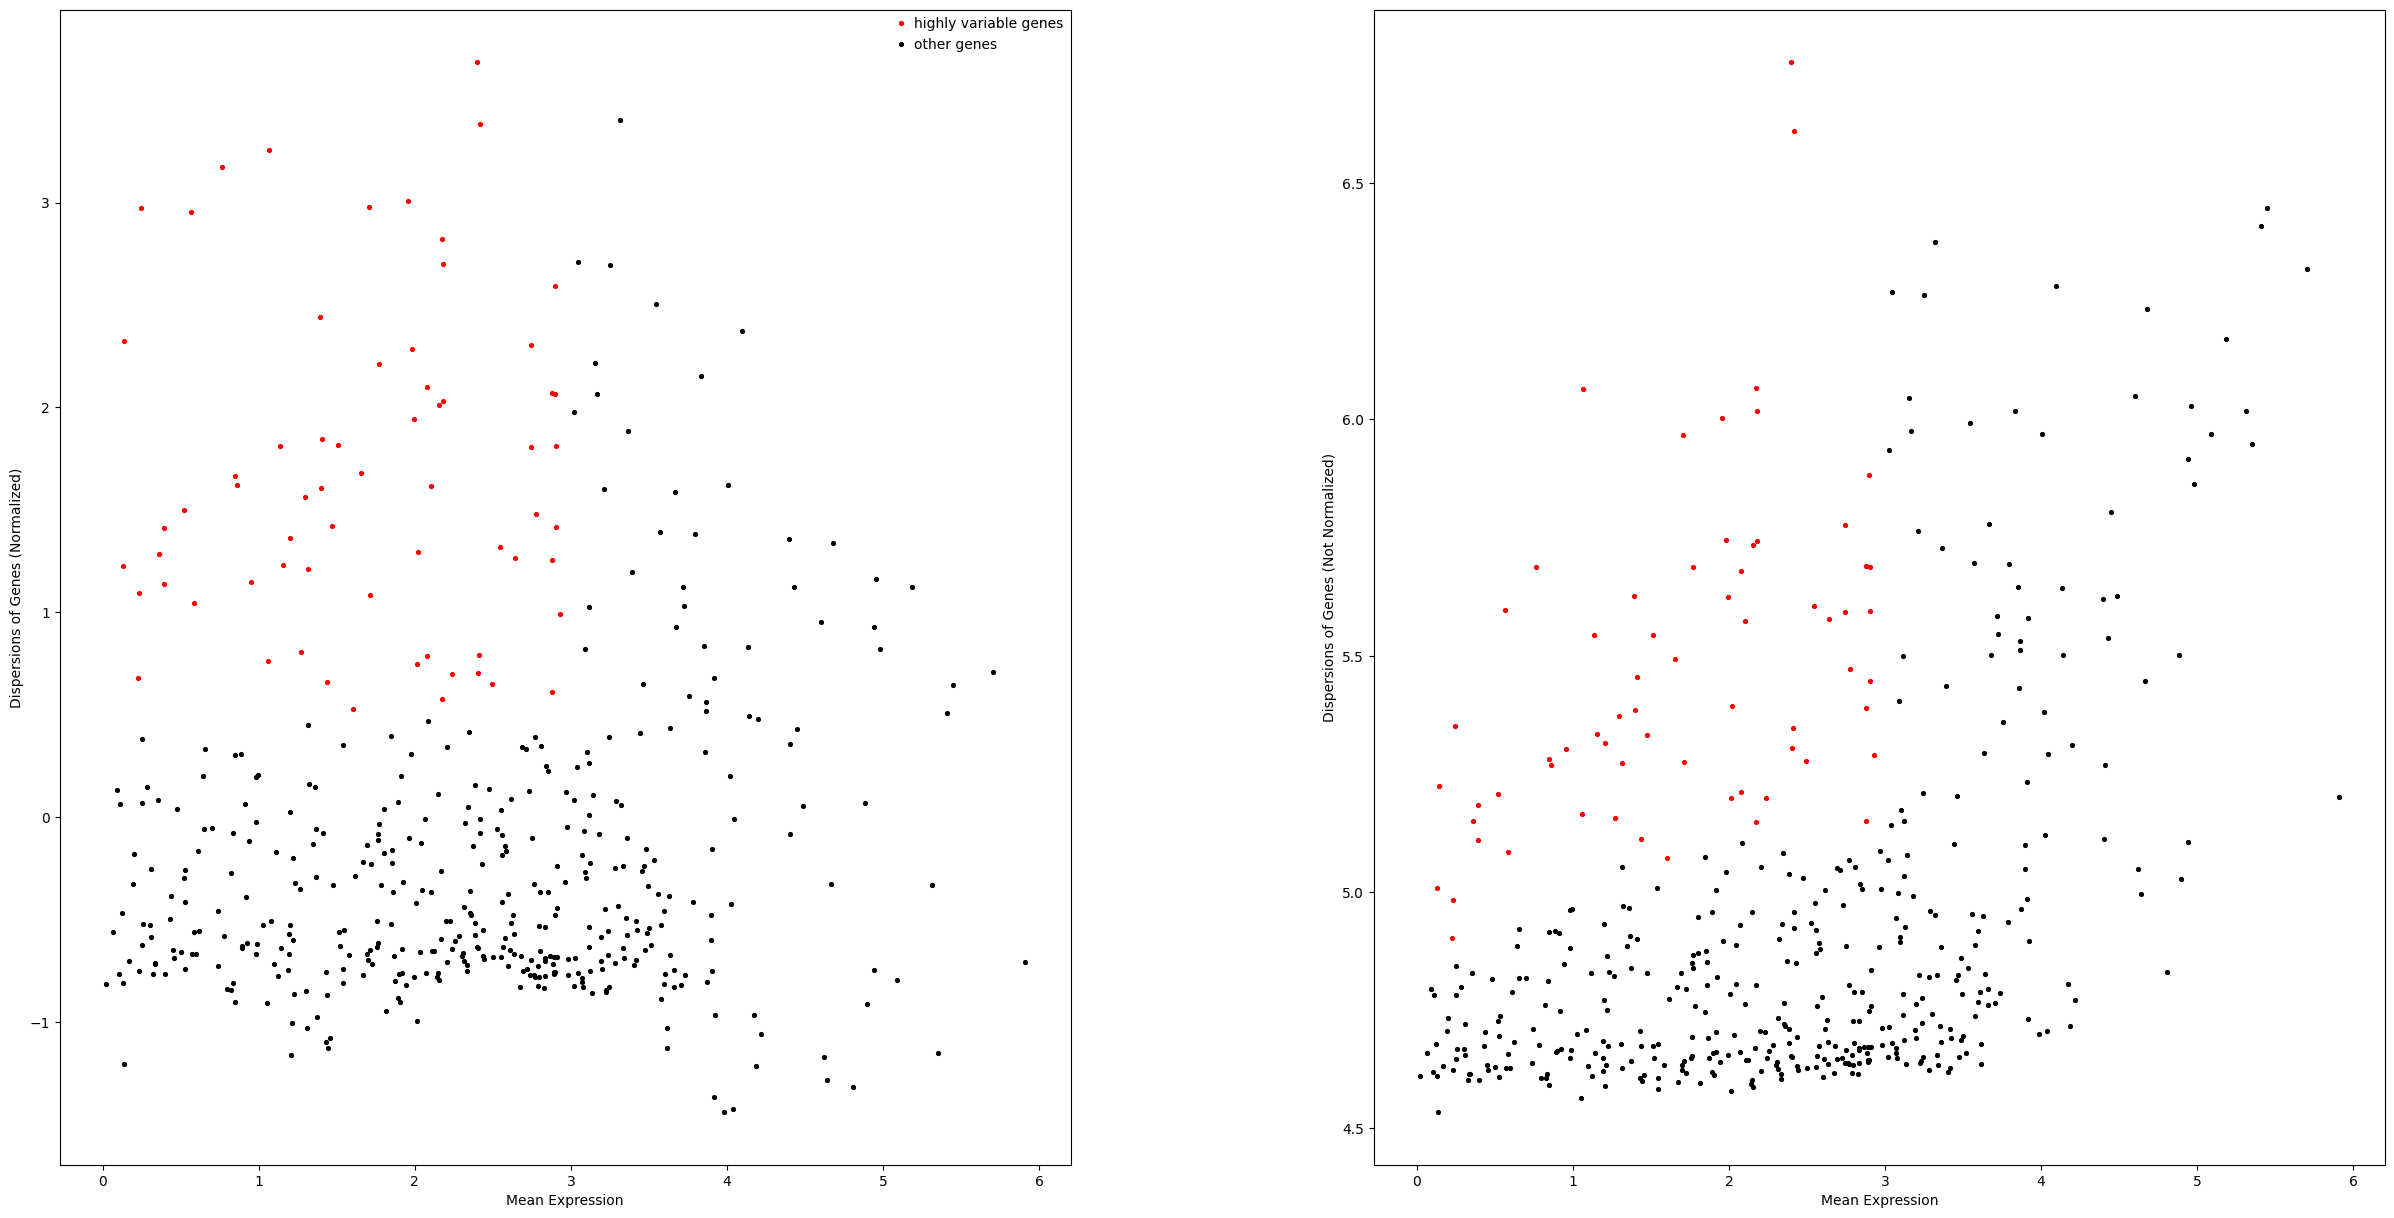


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...


Counts: Post-Processing


	Observations: 380340

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            11525.0     0.032422           0.031907              83.021083   
50%            38583.0     0.103477           0.098466              91.704686   
75%            78972.0     0.246471           0.220316              97.522134   

     total_counts  log1p_total_counts  n_cells  n_counts     means  \
25%       15080.0            9.621191  10761.0   14256.0  1.389578   
50%       48129.0           10.781661  35952.0   46121.0  2.397369   
75%      114638.0           11.649544  74562.0  107845.0  3.178622   

     dispersions  dispersions_norm      mean       std  
25%     4.666910         -0.686892  0.124902  0.750322  
50%     4.818966         -0.335485  0.429385  1.339240  
75%   

MemoryError: Unable to allocate 42.5 GiB for an array with shape (2, 2854071360) and data type object

In [12]:
%%time

self._columns["col_cell_type"] = col_cell_type
if kws_pp not in [None, False]:  # don't re-preprocess if re-loaded object
    _ = self.preprocess(**kws_pp, figsize=(15, 15))  # preprocess
_ = self.cluster(key_added=col_cell_type, out_file=out_obj,
                 genes_subset=genes_subset, use_highly_variable=False,
                 resolution=resolution, n_comps=n_comps,
                 kws_umap=dict(min_dist=min_dist))  # cluster
_ = self.find_markers(n_genes=None, out_file=out_markers)  # DEGs
if out_obj not in [None, False]:
    self.write(out_obj)  # write object

# Annotation

## Automated Annotation 

You can run this if you specified a file above in `file_ann` a file whose first column contains gene names and whose second column contains the cell type label associated with that gene.

In [ ]:
assign = pd.read_csv(file_ann, index_col=0)
col_assign = assign.columns[0]  # default to 1st column; replace if you want
col_annotation = f"{col_assign}_{suffix}"
_ = self.annotate_clusters(assign[[col_assign]],
                           col_cell_type=col_cell_type,
                           col_annotation=col_annotation)

## Manual Annotation

Or, you can perform manual annotation mapping each Leiden cluster to an annotation, save it into an Excel file, and then make a column using that mapping. (Alternatively, you can just manually construct a Python dictionary and use that instead of `dict(assign[col_assign])`.)

In [ ]:
assign = pd.read_excel(file_ann, index_col=[0, 1, 2]).loc[
    self._library_id].loc[col_cell_type]
col_assign = assign.columns[0]  # default to 1st column; replace if you want
col_annotation = f"{col_assign}_{suffix}"
_ = self.annotate_clusters(dict(assign[col_assign]),
                           col_cell_type=col_cell_type,
                           col_annotation=col_annotation)

# Write Files

## Xenium Explorer-Compatible Cell ID-Cluster Mapping

In [ ]:
ct_cols = [k for k in [self._columns["col_cell_type"], col_annotation] if (
    k in self.rna.obs)]  # cell type columns (annotation &/or Leiden)
for c in ct_cols:  # write Leiden clusters, then annotations if available
    self.write_clusters(
        out_dir, col_cell_type=c, overwrite=True,
        file_prefix=f"{s._library_id}__", n_top="find_markers")

## PDFs with Cluster Localization Plots

In [ ]:
ct_cols = [k for k in [self._columns["col_cell_type"], col_annotation] if (
    k in self.rna.obs)]  # cell type columns (annotation &/or Leiden)
for c in ct_cols:  # write Leiden, then annotation column
    self.plot_clusters(col_cell_type=c, out_dir=os.path.join(
        out_dir_plot, f"{c}.pdf"), multi_pdf=True)  # PDFs of spatial plots

# Downstream Analyses

## Cell Type Columns & Genes of Interest

In [ ]:
col_ct = col_annotation if col_annotation in self.rna.obs else col_cell_type
self._columns["col_cell_type"] = col_ct

## Gene Expression Plots

In [ ]:
goi = list(set(pd.unique(functools.reduce(lambda u, v: u + v, [
    genes[g] for g in genes])) if isinstance(genes, dict) else genes
            ).intersection(self.rna.var_names))  # gene list
# fig_gex["spatial"][self._library_id] = self.plot_spatial(
#     color=goi + [col_ct], title=f"{self._library_id}{r}")
pex = "_".join(re.sub("/", "", str(
    f"{self._library_id}{suffix}_{'_'.join(genes)}")).split(" ")) + ".jpeg"
fig_gex["dot"][self._library_id] = cr.pl.plot_dot(
    self.rna, col_ct, genes,
    title=f"{self._library_id}{r}",
    genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
    percent="right", center=None, out_file=os.path.join(
        out_dir_plot, "dot_gex_" + pex))
fig_gex["heat"][self._library_id] = cr.pl.plot_matrix(
    self.rna, col_ct, genes,
    title=f"{self._library_id}{r}",
    genes_dict_colors=genes_dict_colors, vmin=0, vmax=10,
    percent="right", center=None, out_file=os.path.join(
        out_dir_plot, "heat_gex_" + pex))

## Spatial Analyses

In [ ]:
# Spatial Analyses
_, fig_central[self._library_id] = self.calculate_centrality(
    figsize=(20, 10), n_jobs=n_jobs, out_plot=os.path.join(
        out_dir_plot, f"centrality_{self._library_id}{r}{suffix_ct}.jpeg"))
_, fig_neigh[self._library_id] = self.calculate_neighborhood(
    figsize=(60, 30),  out_plot=os.path.join(
        out_dir_plot, f"neighborhood_{self._library_id}{r}{suffix_ct}.jpeg"))
_, fig_cooccur[self._library_id] = self.find_cooccurrence(
    figsize=(60, 20), n_jobs=n_jobs,
    kws_plot=dict(wspace=3), out_plot=os.path.join(
        out_dir_plot, f"cooccurrence_{self._library_id}{r}{suffix_ct}.jpeg"))
_ = self.find_svgs(
    genes=goi, method="moran", n_perms=10, kws_plot=dict(
        legend_fontsize="large"), figsize=(15, 15), n_jobs=n_jobs,
    title=self._library_id,
    out_plot=os.path.join(
        out_dir_plot, f"svg_{self._library_id}{r}{suffix_ct}.jpeg"))
if out_h5ad is not None:
    print(f"Writing {out_h5ad}")
    self.write(out_h5ad)